In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os 
os.chdir("../src/data/")

In [2]:
# %load load.py
"""
"src/data/load.py"

Class definition of data loading/processing/augmentation

"""

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image Augmentation
import numpy as np  # Matrix Operations
import cv2  # Loading images
import os  # Handling files
import matplotlib.pyplot as plt  # Graphing Images
from tqdm import tqdm  # Progress Bar
import argparse  # Terminal
from functools import lru_cache  # Cache Clearing
import sys  # System Utility

try:
    sys.path.insert(1, '../visualization')
    from plotting import plot_imgs 
except ImportError:
    pass

GENERATORS = {
    "train": ImageDataGenerator(rescale=1 / 255),
    "val": None,
    "test": None,
}


class Dataset:
    def __init__(self, path: str, image_augmentation: bool = False) -> None:
        self.path: str = path
        self.image_augmentation: bool = image_augmentation
        self.labels: np.array = np.asarray(os.listdir(os.path.join(self.path, "train")), dtype=object) 
        self.data: dict = {"train": None, "val": None, "test": None}

        self._load()
        if self.image_augmentation:
            self._augment()

    def _augment(self) -> None:
        """
        Utlizes the tensorflow ImageDataGenerator to augment images
        :return: None
        """
        for subset, generator in GENERATORS.items():
            if generator:
                flow = generator.flow(self.dataset[subset][0])
                self.dataset[subset] = np.concatenate([[flow.next()[0], flow.next()[1]]
                                                       for _ in range(flow.__len__())])

    def _load(self) -> None:
        """
        Loads all the images in the given the path
        :return: None
        """
        for key in self.data.keys():
            path = os.path.join(self.path, key)
            images, labels, names = [], [], []

            #for label in tqdm(self.labels, desc=f"{key.upper()}", ncols=75):  
            for label in self.labels:
                loaded_imgs, loaded_names = self._load_imgs(os.path.join(path, label))
                loaded_labels = self._encode(label)
                
                images.extend(loaded_imgs)
                labels.extend([loaded_labels for _ in loaded_imgs])
                names.extend(loaded_names) 
            
            self.data[key] = (np.asarray(images, dtype=np.uint8), np.asarray(labels, dtype=np.uint8), np.asarray(names, dtype=np.object))

    @staticmethod
    @lru_cache(maxsize=None)
    def _load_imgs(path) -> np.array:
        """
        Utilizes the path of the classes of images in order to store the images located in that directory.
        :param path: Directory of feature
        :return: Numpy array of images
        """
        imgs, names = [], []
        for image_path in os.listdir(path):
            if image_path.endswith('.jpg'):
                tmp_path = os.path.join(path, image_path)
                image = np.reshape(cv2.imread(tmp_path, cv2.IMREAD_GRAYSCALE), (1, 200, 200, 1))                
                names.append([image_path])
                imgs.extend(image) 
        return np.asarray(imgs, dtype=np.uint8), np.asarray(names, dtype=np.object)

    def _encode(self, label) -> np.array:
        """
        This functions use is to encode the label based off the one hot encoding method. It creates an empty array
        (filled with zeros) and sets the label equal to one.
        :param label: Number (0-15) that dictates the number to be set to 1
        :return: One-hot encoded numpy array
        """
        possible_labels = np.zeros((len(self.labels), 1))
        possible_labels[np.array(self.labels == label)] = 1 
        return possible_labels

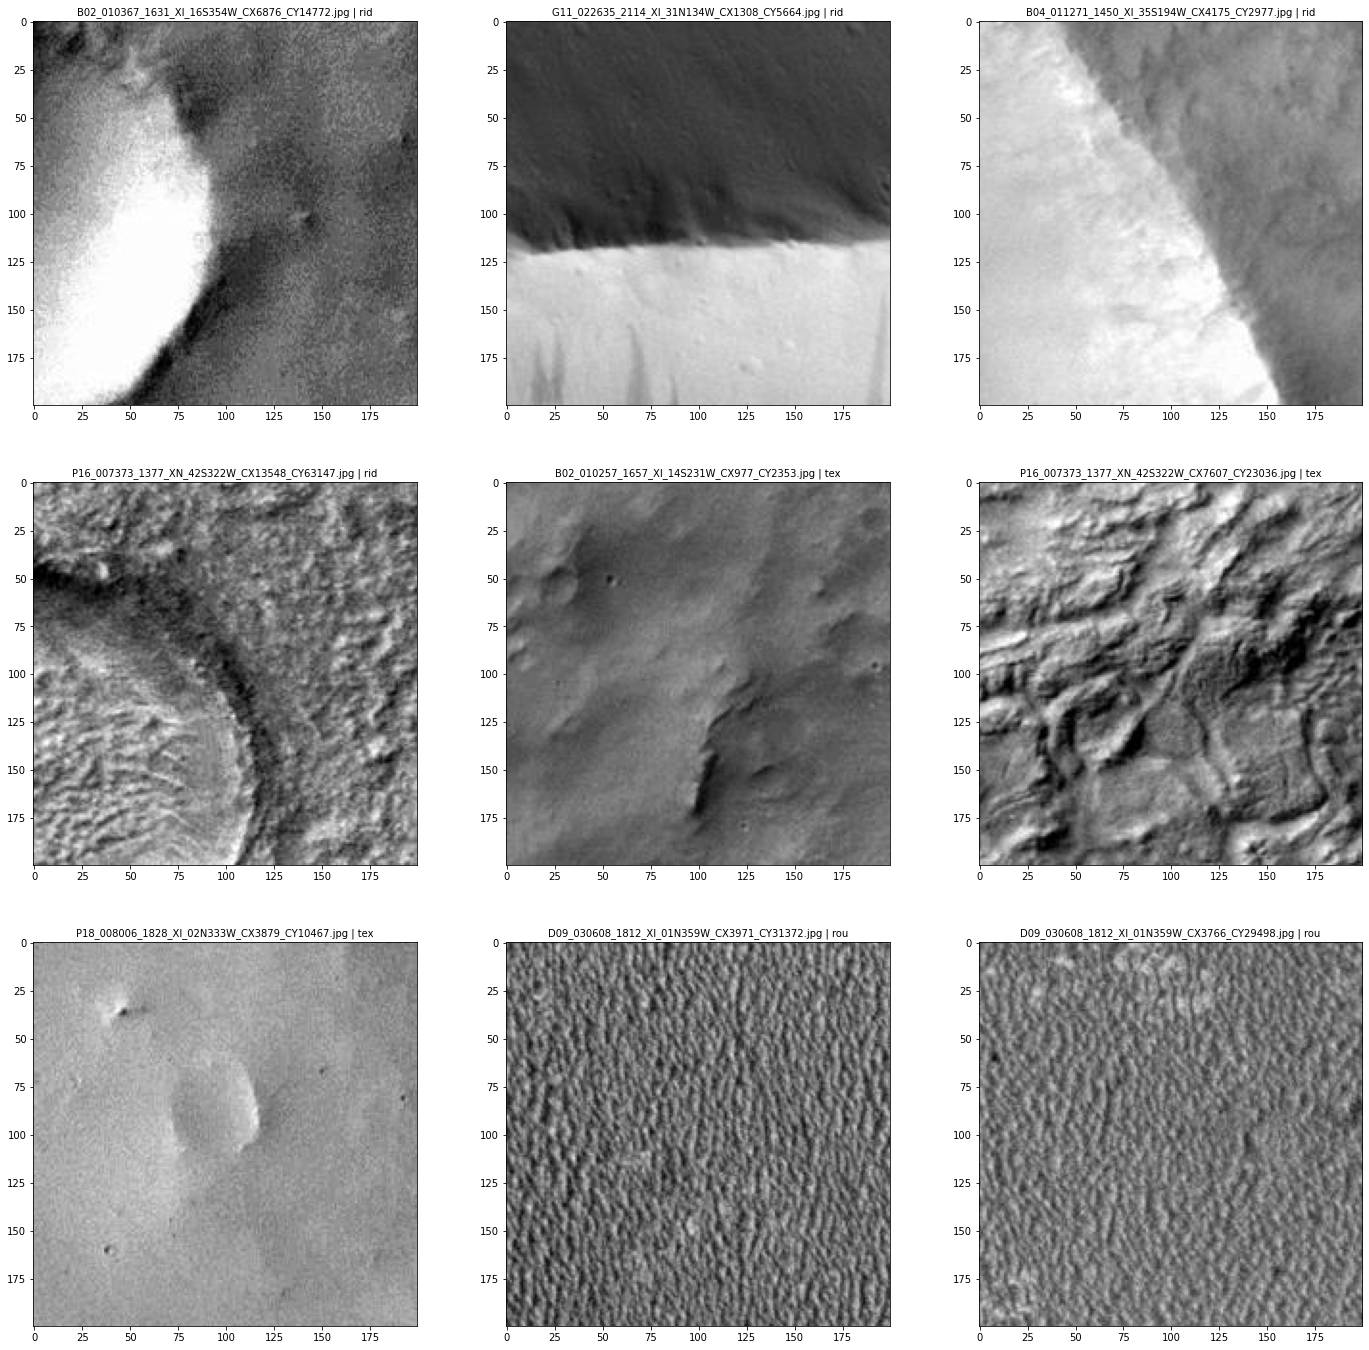

In [3]:
os.chdir(os.path.expanduser("~"))

loader = Dataset("/home/zayn/Desktop/Programming/PYTHON/ML/MarsNet/data/raw/data", False)

examples = loader.data["train"]
label_names = loader.labels

sample_indexes = np.linspace(start=0, stop=len(examples[0]), endpoint=False, retstep=10, dtype=np.int32) 

sample_imgs = examples[0][sample_indexes[0]]     
sample_labels = examples[1][sample_indexes[0]]
sample_names = examples[2][sample_indexes[0]]

sample_names = sample_names[:, 0]
sample_labels = label_names[[np.where(sample == 1)[0] for sample in sample_labels]][:, 0] 

plot_imgs(sample_imgs, sample_names, sample_labels, graph_shape=(3, 3))


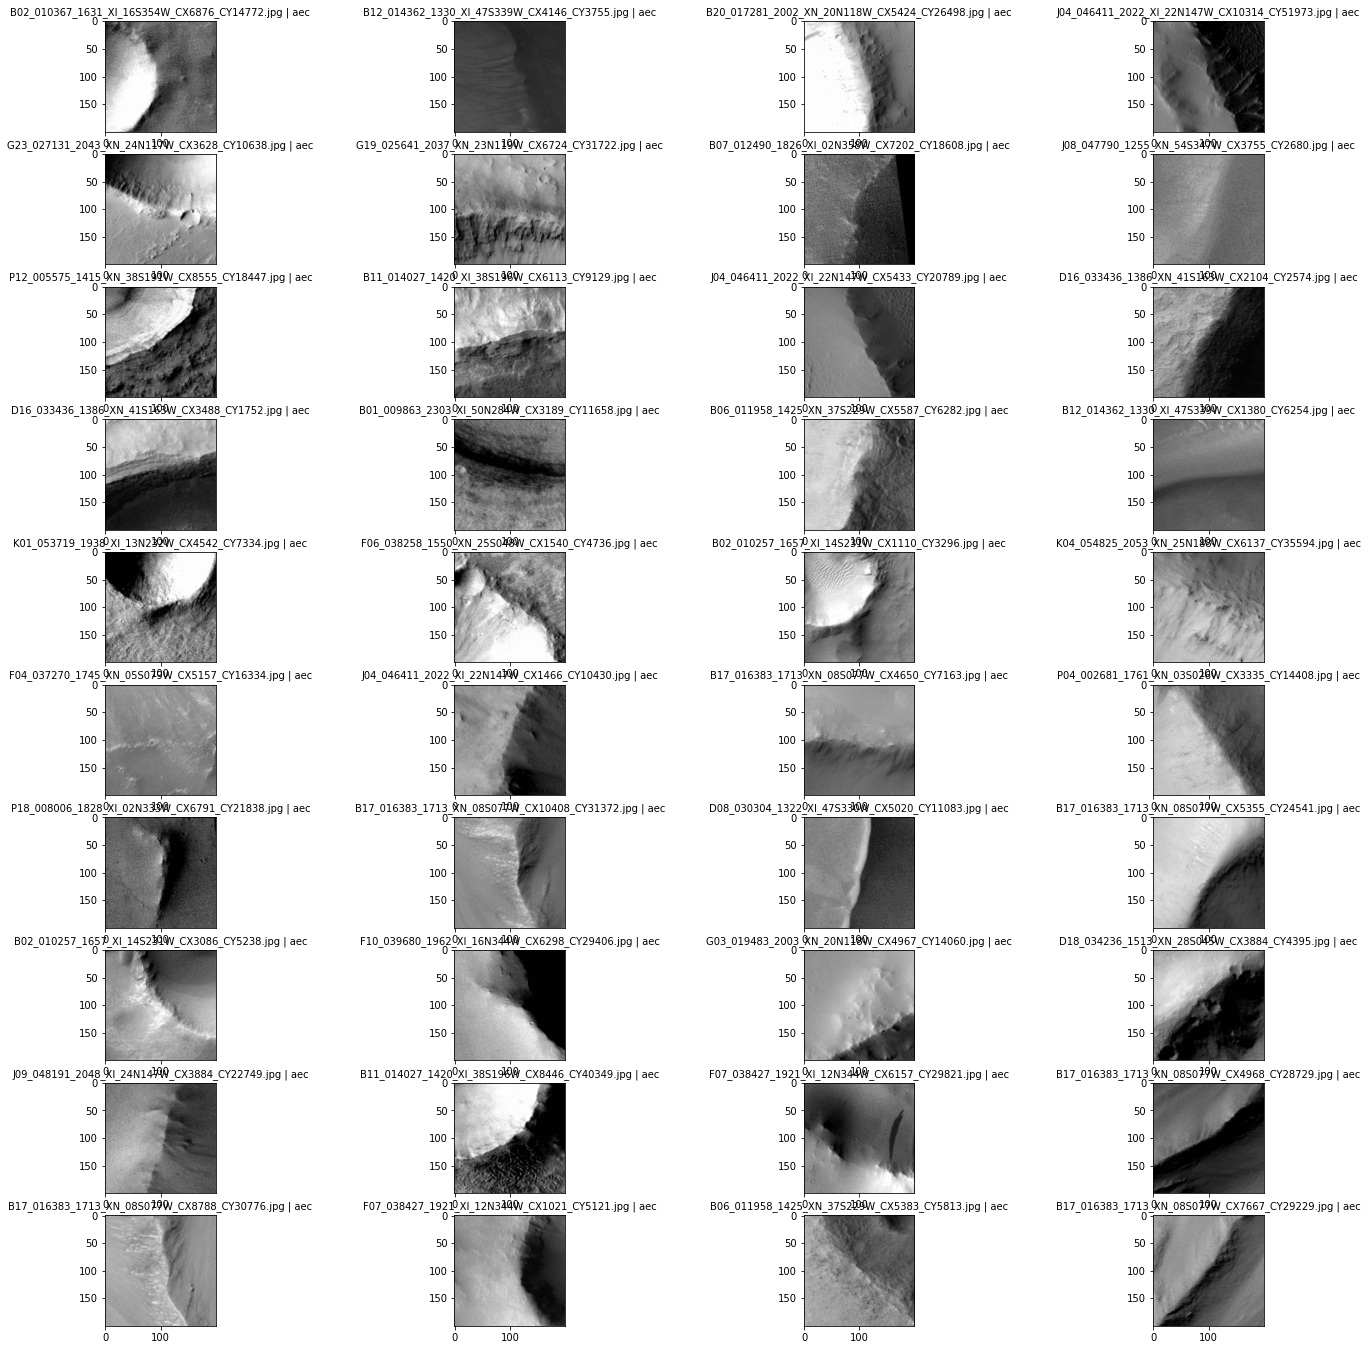

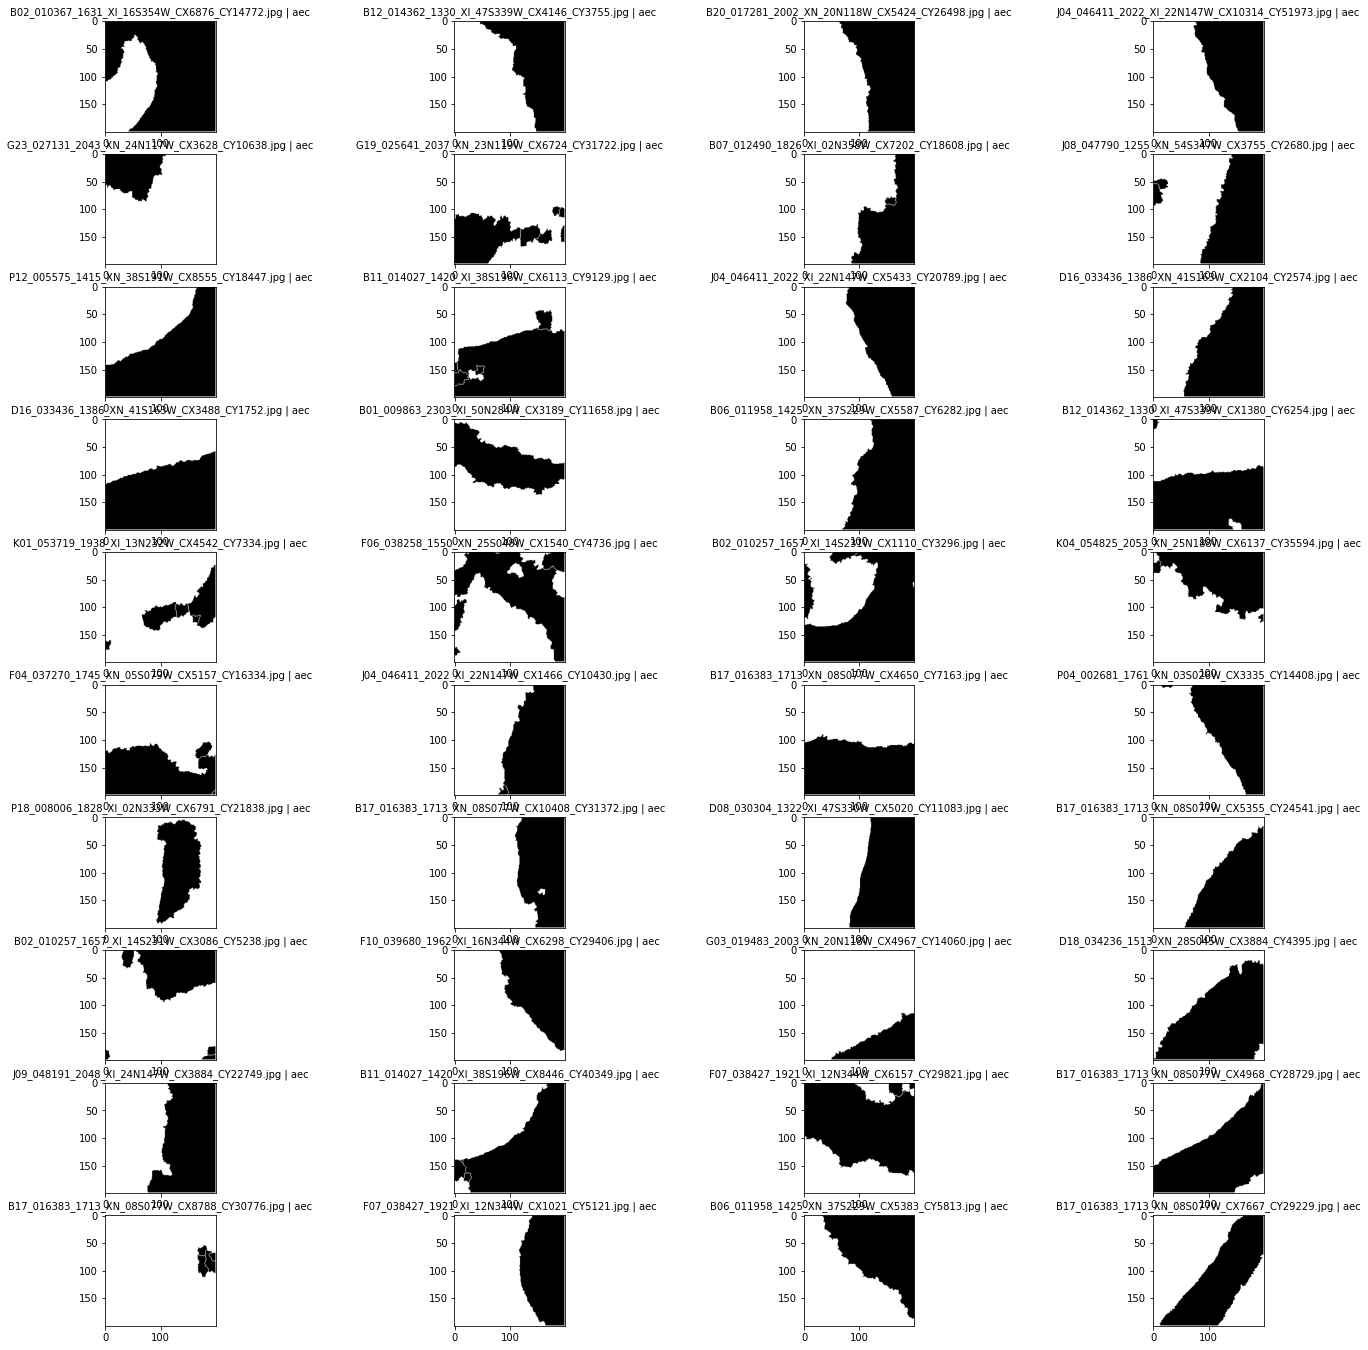

B20_017281_2002_XN_20N118W_CX5424_CY26498.jpg


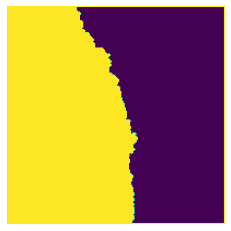

In [11]:
"""WATERSHED ALGORITHM"""
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imutils


def watershed_aec(sample_imgs, sample_names, sample_labels):
    imgs = []
    for img in sample_imgs:
        ret, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

        # noise removal
        kernel = np.ones((3, 3), np.uint8)
        opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations = 4)

        # sure background area
        sure_bg = cv.dilate(opening,kernel,iterations=6)

        # Finding sure foreground area
        dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
        ret, sure_fg = cv.threshold(dist_transform, .01 * dist_transform.max(), 255, 0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv.subtract(sure_bg, sure_fg)
        
        # Marker labelling
        ret, markers = cv.connectedComponents(sure_fg)
        
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1
        
        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0
        
        # Apply Watershed
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        labels = cv2.watershed(img, markers)
        
        markers = cv.watershed(img,markers)
        img[markers == -1] = [255, 0, 0]
        
        #Finding Contours
        m = cv2.convertScaleAbs(markers)
        ret, thresh = cv2.threshold(m,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        
        imgs.append(thresh)

    plot_imgs(sample_imgs, sample_names, sample_labels, graph_shape=(10, 4))
    plot_imgs(imgs, sample_names, sample_labels, graph_shape=(10, 4))
    
    print(sample_names[2])
    img = plt.imshow(imgs[2])
    plt.axis('off')
    plt.savefig("test.png", bbox_inches='tight')


aec_search_label = np.zeros((len(label_names), 1))
aec_search_label[np.array(label_names == "rid")] = 1 
aec_idxs = []
for idx, label in enumerate(examples[1]):
    if np.array_equal(label, aec_search_label):
        aec_idxs.append(idx)

aec_images = examples[0][aec_idxs]     
aec_labels = ["aec" for _ in aec_idxs]
aec_names = examples[2][aec_idxs][:, 0]

watershed_aec(aec_images, aec_names, aec_labels)